In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import librosa
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import h5py
from pathlib import Path
from torch.utils import data
import logging
from datetime import datetime
from collections import Counter

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay



In [2]:
# Wrapping the dataset with load function
class CustomDataset(data.Dataset):
    def __init__(self, file_path, transform=None):
        super().__init__()
        self.train_data_cache = []
        self.test_data_cache = []
        self.manual_data_cache = []
        self.transform = transform
        self.label_count = [0, 0, 0]
        # Search for all h5 files
        p = Path(file_path)
        files = p.glob('*.h5')
        logging.debug(files)
        for h5dataset_fp in files:
            logging.debug(h5dataset_fp)
            with h5py.File(h5dataset_fp.resolve()) as h5_file:
                # Walk through all groups, extracting datasets
                for gname, group in h5_file.items():
                    k = 0
                    j = 0
                    l = 0
                    if gname == 'referenz':
                        label = 0
                    elif gname == 'spitze':
                        label = 1
                    elif gname == 'grenzflaeche':
                        label = 2

                    logging.debug(group.items())
                    for dname, ds in tqdm(group.items()):
                        if k < 3000:
                            for i in np.split(ds, 4):
                                self.train_data_cache.append([label, torch.tensor(i).unsqueeze(0).type(torch.float32)])
                                k += 1
                        elif j < 400:
                            for i in np.split(ds, 4):
                                self.test_data_cache.append([label, torch.tensor(i).unsqueeze(0).type(torch.float32)])
                                j += 1
                        elif l < 100:
                            for i in np.split(ds, 4):
                                self.manual_data_cache.append([label, torch.tensor(i).unsqueeze(0).type(torch.float32)])
                                l += 1
                                
    def __getitem__(self, index):
        return self.data_cache[index]

    def get_test_data(self):
        return self.test_data_cache

    def get_train_data(self):
        return self.train_data_cache

    def __len__(self):
        return len(self.data_cache)

In [3]:
# Defining the network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv1d(1, 2, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(2, 4, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(4, 8, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(8, 16, kernel_size=3, padding=1)  # endsize 1536 maxpool 3
        # self.conv5 = nn.Conv1d(128, 256, kernel_size=3, padding=1) #endsize 1024 maxpool 3
        # self.conv6 = nn.Conv1d(256, 512, kernel_size=3, padding=1) # endsize 512 maxpool 3

        self.fc1 = nn.Linear(384//8, 3)

    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)), 3)
        x = F.max_pool1d(F.relu(self.conv2(x)), 3)
        x = F.max_pool1d(F.relu(self.conv3(x)), 3)
        x = F.max_pool1d(F.relu(self.conv4(x)), 3)
        # x = F.max_pool1d(F.relu(self.conv5(x)),3)
        # x = F.max_pool1d(F.relu(self.conv6(x)),3)
        #logging.debug(x.shape)
        x = torch.flatten(x, 1)
        #logging.debug(x.shape)
        x = F.softmax(self.fc1(x), dim=1)

        return x

In [4]:

# the train loop
def train(dataloader, optimizer, criterion, model):
    model.train()
    running_loss = 0.0
    j = 0
    loss_values = []
    #data=next(iter(train_dataloader))
    #inputs = data[1]
    #labels = data[0]
    #print( labels)
   
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [labels, inputs]

        inputs = data[1]
        labels = data[0]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    
        # log statistics
        running_loss += loss.item()
        #print(torch.argmax(outputs,axis=1))
        #print((torch.argmax(outputs,axis=1)==labels).float().mean())
        if i % 500 == 499:
            print(f"[{epoch}]Loss: {running_loss / 500} ")
        
    print(f"[{epoch}] Train Loss: {running_loss / (i+1)} ") 
    plt.plot(loss_values)

In [5]:
# testing the accuracy on single 1024 snippets
def split_test(dataloader,criterion, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    ACC = []
    true = []
    pred = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for labels, inputs in dataloader:
            labels, inputs = labels.to(device), inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            ACC.append((torch.argmax(outputs,axis=1)==labels).float().mean().item())
            pred.extend(list((torch.argmax(outputs,axis=1).cpu().numpy())))
            true.extend(list(labels.cpu().numpy()))
            correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f" Random Teilstück Error: Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    #print('Jetzt kommt Test',np.mean(ACC))
    
    return confusion_matrix(true, pred), confusion_matrix(true, pred, normalize='true')



In [6]:
# looking for cuda device and selecting it if possible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [7]:
# loading the data
customData = CustomDataset('data')



<ipython-input-2-6cd89fd886d4>:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(h5dataset_fp.resolve()) as h5_file:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3401/3401 [00:00<00:00, 10119.73it/s]


In [8]:
# defining the model and moving it to the correct device


In [9]:
# defining train and test sets
train_data = customData.get_train_data()
test_data = customData.get_test_data()
train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True, pin_memory=False, num_workers=0)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=0)
manual_dataloader = DataLoader(customData.manual_data_cache, batch_size=4, shuffle=False, pin_memory=False, num_workers=0)

In [10]:

cache=[]
for i, val in enumerate( train_data):
        train_data[i][0]
        cache.append(train_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([2, 0, 1])
dict_values([3000, 3000, 3000])


In [11]:
cache=[]
for i, val in enumerate( test_data):
        test_data[i][0]
        cache.append(test_data[i][0])
    
print(Counter(cache).keys())
print(Counter(cache).values())

dict_keys([2, 0, 1])
dict_values([400, 400, 400])


Network(
  (conv1): Conv1d(1, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(2, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=48, out_features=3, bias=True)
)
687
[0] Train Loss: 1.068744765387641 
 Random Teilstück Error: Accuracy: 35.2%, Avg loss: 1.019044
[1] Train Loss: 1.001400379670991 
 Random Teilstück Error: Accuracy: 52.8%, Avg loss: 0.979946
[2] Train Loss: 0.9540769755840302 
 Random Teilstück Error: Accuracy: 68.1%, Avg loss: 0.922195
[3] Train Loss: 0.8650969349675708 
 Random Teilstück Error: Accuracy: 81.5%, Avg loss: 0.808328
[4] Train Loss: 0.7643632888793945 
 Random Teilstück Error: Accuracy: 82.8%, Avg loss: 0.739987
[5] Train Loss: 0.7142507218652301 
 Random Teilstück Error: Accuracy: 85.7%, Avg loss: 0.702729
[6] Train Loss: 0.691096532675955 
 Random Teilstück Error: Accuracy:

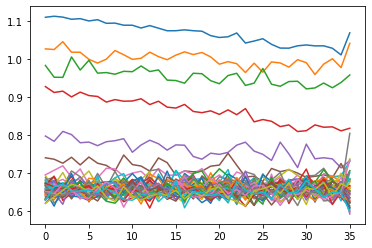

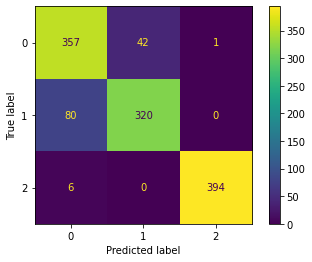

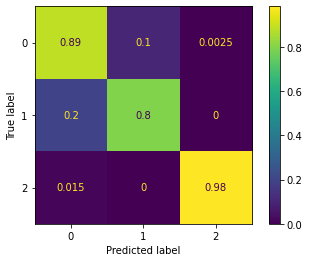

In [12]:


model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

# defining loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(50):  # loop over the dataset multiple times
    loss_values=train(train_dataloader, optimizer, criterion, model)
    CM=split_test(test_dataloader, criterion, model)
    #test_complete(test_dataloader, optimizer, criterion, model)
print('Finished Training')
#print(CM[0])

disp = ConfusionMatrixDisplay(confusion_matrix=CM[0],display_labels=[0, 1, 2])
disp.plot()
plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=CM[1],display_labels=[0, 1, 2])
disp.plot()
plt.show()





In [13]:
model.eval()
for labels, inputs in manual_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    logging.debug(model(inputs), labels)

    